# Pose Approximation Refinement

Expected Data format:

- `x` - images (B, 224, 224, 3)
- `y` - ground truth vertices for hand landmarks (B, 21, 2)

In [3]:
!pip install lmdb

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.1/295.1 kB 6.0 MB/s eta 0:00:00ta 0:00:01


In [1]:
import torch

class classproperty(property):
    def __get__(self, obj, cls):
        return self.fget(cls)

class Hand:
    # NOTE: MediaPipe 21 point Hand landmark model: https://mediapipe.readthedocs.io/en/latest/solutions/hands.html
    _RAW_CONNECTIONS = [
        (0,1), (0,5), (0,17), (1,2), (2,3), (3,4),
        (5,6), (5,9), (6,7), (7,8), (9,10), (9,13),
        (10,11), (11,12), (13,14), (13,17), (14,15),
        (15,16), (17,18), (18,19), (19,20)
    ]

    NUM_POINTS = 21
    NUM_FEATURES = 2 # x, y only
    
    @classproperty
    def anatomical(cls):
        # Create the edge list and make it undirected by adding reverse connections (same for all graphs)
        temp = []
        for a, b in cls._RAW_CONNECTIONS:
            temp.append([a, b])
            temp.append([b, a])  # Add the reverse connection
        return temp
    
    @classproperty
    def inverse_anatomical(cls):
        inverse_graph_connections = []
        for i in range(21):
            for j in range(21):
                conn = (i, j)
                if conn not in cls._RAW_CONNECTIONS and i != j:
                    inverse_graph_connections.append(conn)
        return inverse_graph_connections
    
    @staticmethod
    def compute_edge_index(connection_choice):
        return torch.tensor(connection_choice, dtype=torch.long).t().contiguous()

Hand.compute_edge_index(Hand.anatomical)

tensor([[ 0,  1,  0,  5,  0, 17,  1,  2,  2,  3,  3,  4,  5,  6,  5,  9,  6,  7,
          7,  8,  9, 10,  9, 13, 10, 11, 11, 12, 13, 14, 13, 17, 14, 15, 15, 16,
         17, 18, 18, 19, 19, 20],
        [ 1,  0,  5,  0, 17,  0,  2,  1,  3,  2,  4,  3,  6,  5,  9,  5,  7,  6,
          8,  7, 10,  9, 13,  9, 11, 10, 12, 11, 14, 13, 17, 13, 15, 14, 16, 15,
         18, 17, 19, 18, 20, 19]])

In [21]:
import torch
from torch.utils.data import Dataset, DataLoader
import pickle
import lmdb

class PoseLMDBDataset(Dataset):
    def __init__(self, lmdb_path):
        self.env = lmdb.open(lmdb_path,
            readonly=True, lock=False,
            readahead=False, meminit=False)
        self.txn = self.env.begin(write=False)
        self.length = self.txn.stat()['entries']

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        key = f"{idx:08d}".encode('ascii')
        byteflow = self.txn.get(key)
        sample = pickle.loads(byteflow)
        img = sample["image"]
        label = sample["label"]

        img = torch.from_numpy(img).float() / 255.0
        assert img.shape[0] == img.shape[1], "Only square images are supported!"
        label = torch.tensor(label) / (img.shape[0]-1) * 2 - 1 # map between -1, 1
        return img, label

In [22]:
from torch.utils.data import random_split, DataLoader

BASE_PATH = "/kaggle/input/freihand-reloaded"
dataset = PoseLMDBDataset(f"{BASE_PATH}/training_data.lmdb")
test_dataset = PoseLMDBDataset(f"{BASE_PATH}/evaluation_data.lmdb")

train_size = int(0.9 * len(dataset))
valid_size = len(dataset) - train_size

train_dataset, valid_dataset = random_split(dataset, [train_size, valid_size])

BATCH_SIZE = 256
# NOTE: num_workers > 0 is not supported by the Dataset
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=True)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True)

images, labels = next(iter(train_loader))
print(images.shape, labels.shape)

torch.Size([256, 224, 224, 3]) torch.Size([256, 21, 2])


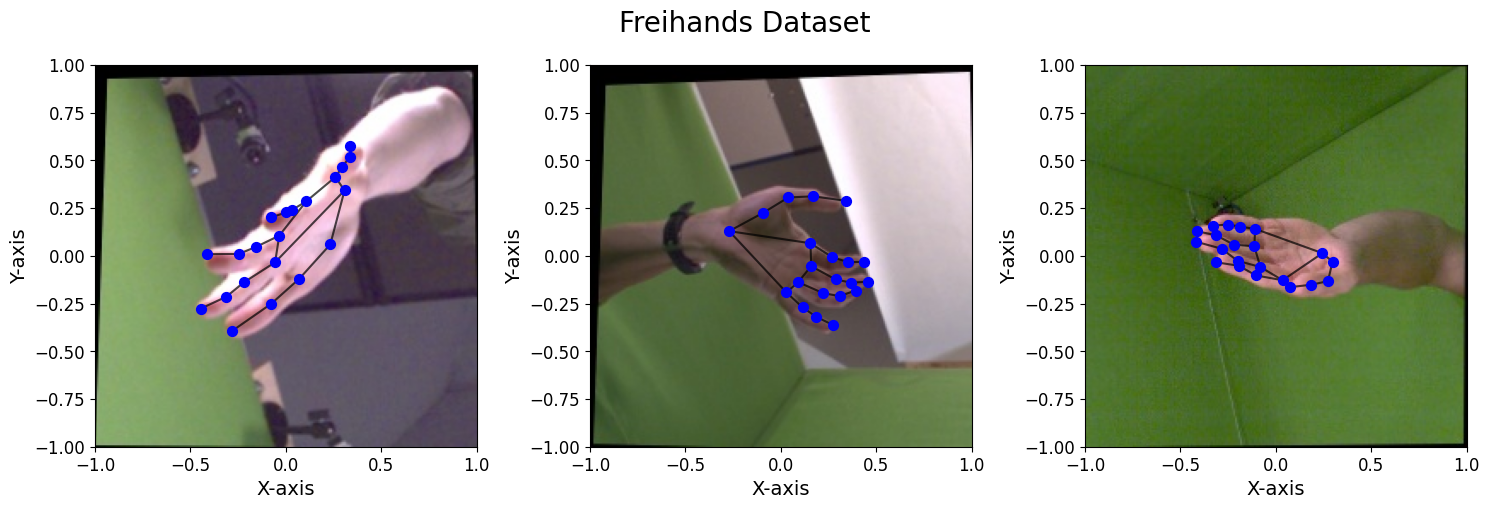

In [30]:
import random
import networkx as nx
import matplotlib.pyplot as plt

def visualize_graphs_side_by_side(dataset, indices):
    num_graphs = len(indices)
    fig, axs = plt.subplots(1, num_graphs, figsize=(5 * num_graphs, 5))
    axs = [axs] if num_graphs == 1 else axs

    fig.suptitle("Freihands Dataset", fontsize=20)

    for ax, idx in zip(axs, indices):
        img, lms = dataset[idx]
        img, lms = img.numpy(), lms.numpy()

        # Background image (fit to 0-1 coordinate space)
        ax.imshow(img, extent=[-1, 1, 1, -1], origin='upper', aspect='auto')

        # Graph edges
        edge_index = Hand.compute_edge_index(Hand.anatomical).numpy()
        G = nx.Graph()
        G.add_edges_from(edge_index.T)

        # Node features
        x, y = lms[:, 0], lms[:, 1]
        pos_x = {i: (x[i], y[i]) for i in range(len(x))}
        nx.draw_networkx_nodes(G, pos_x, node_size=50, node_color='blue', ax=ax)
        nx.draw_networkx_edges(G, pos_x, width=1.5, alpha=0.7, ax=ax)

        ax.set_aspect('equal', adjustable='box')
        ax.set_xlim(-1, 1)
        ax.set_ylim(-1, 1)
        # ax.invert_yaxis()
        ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True, labelsize=12)
        ax.set_xlabel("X-axis", fontsize=14)
        ax.set_ylabel("Y-axis", fontsize=14)

    plt.tight_layout()
    plt.show()

# Example usage
random_indices = random.sample(range(len(dataset)), 3)
visualize_graphs_side_by_side(dataset, indices=random_indices)

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class MobileGNNConv(nn.Module):
    """Custom implementation of GCNConv in Pytorch for Static ASL Fingerspelling sign classification.

    The implementation optimizes the general GCN by making the adjacency matrix, denoted 'A', fixed in size for classic batching.
    It also allows for optimizing the values of the said matrix via gradient descent and dynamically freezing the weights.
    """
    def __init__(self, input_dim: int, output_dim: int):
        super(MobileGNNConv, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.lin = nn.Linear(input_dim, output_dim, bias=False)

        A = torch.zeros((Hand.NUM_POINTS, Hand.NUM_POINTS))
        for x, y in Hand.anatomical:
          A[x, y] = 1

        A_hat = A + torch.eye(A.size(0)) # self loops
        D = torch.diag(A_hat.sum(dim=1))
        D_neg_sqrt = torch.linalg.inv(torch.sqrt(D))
        A_norm = D_neg_sqrt @ A_hat @ D_neg_sqrt
        self.A_norm = nn.Parameter(A_norm, requires_grad=False) # Constant by default

    def set_adjancency(self, trainable: bool):
        self.A_norm.requires_grad = trainable

    def forward(self, X: torch.Tensor):
        # ReLU(D^-1/2 * A_hat * D^-1/2 * X * W)
        return F.relu(self.lin(self.A_norm @ X))

    def __repr__(self):
        return self.__class__.__name__ + ' (' + str(self.input_dim) + ' -> ' + str(self.output_dim) + ')'

In [18]:
class SimplePoseModel(nn.Module):
    def __init__(self, num_features=Hand.NUM_FEATURES):
        super().__init__()
        self.num_features = num_features
        self.extract_features = nn.Sequential(
            nn.Conv2d(3, 16, 3, stride=2, padding=1),  # (B, 16, 112, 112)
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),  # (B, 32, 56, 56)
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=2, padding=1),  # (B, 64, 28, 28)
            nn.ReLU(),
            nn.Conv2d(64, 128, 3, stride=2, padding=1), # (B, 128, 14, 14)
            nn.ReLU(),
            nn.AdaptiveAvgPool2d(1)  # (B, 128, 1, 1)
        )
        # Regressor to keypoints
        self.fc = nn.Linear(128, Hand.NUM_POINTS * self.num_features)

    def forward(self, x):
        # x: (B, 3, 224, 224)
        B = x.size(0)
        features = self.extract_features(x) # (B, 128, 1, 1)
        features = features.view(B, -1)     # (B, 128)
        out = self.fc(features)             # (B, 42)
        return out.view(
            B, Hand.NUM_POINTS, self.num_features
        )

In [54]:
from torchvision.models import resnet18, ResNet18_Weights

class ResnetPoseModel(nn.Module):
    def __init__(self, frozen=False):
        super().__init__()
 
        # ResNet18 backbone
        resnet = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1, progress=False)
        self.resnet = nn.Sequential(*list(resnet.children())[:-1])  # remove FC
        # Freeze all parameters of ResNet
        if frozen:
            for param in self.resnet.parameters():
                param.requires_grad = False
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(512, Hand.NUM_POINTS * Hand.NUM_FEATURES)
 
    def forward(self, images: torch.Tensor):
        """
        images: (B, H, W, 3)
        returns: (B, 21, 2)
        """
        B = images.size(0)
        images = images.permute(0, 3, 1, 2) # (B, 3, H, W)
        x = self.resnet(images)  # (B, 512, 1, 1)
        x = self.flatten(x)      # (B, 512)
        x = self.fc(x)           # (B, 42)
        x = x.view(B, Hand.NUM_POINTS, Hand.NUM_FEATURES)  # (B, 21, 2)
        return x

# Example usage
model = ResnetPoseModel()
dummy_input = torch.randn(4, 224, 224, 3)
coords = model(dummy_input)
print(coords.shape)    # (4, 21, 2)
#print(heatmaps.shape)  # (4, 21, 112, 112)

torch.Size([4, 21, 2])


In [19]:
import torch.nn as nn

latent_space_dim = 64

class HandGCN(nn.Module):
    def __init__(self, backbone: nn.Module, gcn_latent_dim=64):
        super().__init__()
        self.backbone = backbone
        self.gcn1 = MobileGNNConv(latent_space_dim, gcn_latent_dim)
        self.gcn2 = MobileGNNConv(gcn_latent_dim, Hand.NUM_FEATURES)

    def forward(self, images: torch.Tensor):
        """
        images: (B, H, W, 3)
        returns: (B, 21, 2)
        """
        B = images.size(0)
        images = images.permute(0, 3, 1, 2) # (B, 3, H, W)
        x = self.backbone(images)  # (B, 21, 2)

        # Refine coordinates using GCN
        x = self.gcn1(x)
        x = self.gcn2(x)
        return x
    
model = HandGCN(backbone=SimplePoseModel(num_features=latent_space_dim), gcn_latent_dim=64)

In [44]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SimpleHandHeatmapModel(nn.Module):
    def __init__(self, num_keypoints=21, heatmap_size=112):
        super().__init__()
        self.num_keypoints = num_keypoints
        self.heatmap_size = heatmap_size

        # Encoder
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv4 = nn.Conv2d(128, 256, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)

        # Decoder / Upsampling
        self.up1 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.up2 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.up3 = nn.ConvTranspose2d(64, 32, 2, stride=2)
        self.up4 = nn.Conv2d(32, num_keypoints, 1)  # heatmaps

    def forward(self, x):
        # Permute input to (B, C, H, W)
        x = x.permute(0, 3, 1, 2)

        # Encoder
        x = F.relu(self.pool(self.conv1(x)))  # 224->112
        x = F.relu(self.pool(self.conv2(x)))  # 112->56
        x = F.relu(self.pool(self.conv3(x)))  # 56->28
        x = F.relu(self.pool(self.conv4(x)))  # 28->14

        # Decoder
        x = F.relu(self.up1(x))  # 14->28
        x = F.relu(self.up2(x))  # 28->56
        x = F.relu(self.up3(x))  # 56->112
        heatmaps = self.up4(x)   # (B, num_keypoints, H, W)

        # Save H and W for soft-argmax
        B, K, H, W = heatmaps.shape

        # Flatten for softmax
        heatmaps_flat = heatmaps.view(B, K, -1)
        heatmaps_prob = F.softmax(heatmaps_flat, dim=2)

        # Create coordinate grids
        grid_y, grid_x = torch.meshgrid(
            torch.linspace(0, 1, H, device=x.device),
            torch.linspace(0, 1, W, device=x.device),
            indexing='ij'
        )
        grid_x = grid_x.reshape(-1)
        grid_y = grid_y.reshape(-1)

        x_coords = (heatmaps_prob * grid_x).sum(dim=2)
        y_coords = (heatmaps_prob * grid_y).sum(dim=2)

        coords = torch.stack([x_coords, y_coords], dim=2)  # (B, K, 2)

        return coords#, heatmaps  # heatmaps keep original shape (B, 21, H, W)

# Example usage
model = SimpleHandHeatmapModel()
dummy_input = torch.randn(4, 224, 224, 3)
coords = model(dummy_input)
print(coords.shape)    # (4, 21, 2)
#print(heatmaps.shape)  # (4, 21, 112, 112)

torch.Size([4, 21, 2])


In [45]:
def count_parameters(model):
    total = sum(p.numel() for p in model.parameters())
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total, trainable

total, trainable = count_parameters(model)
print(f"Total parameters: {total}")
print(f"Non-Trainable parameters: {total- trainable}")

Total parameters: 561365
Non-Trainable parameters: 0


In [55]:
import torch.optim as optim

def pck(preds, targets, threshold=0.05):
    """
    Computes PCK (Percentage of Correct Keypoints within a tolerance)
    """
    dists = torch.norm(preds - targets, dim=-1)
    correct = (dists < threshold).float()
    return correct.mean().item()

def train_pose_model(model: nn.Module, train_loader: DataLoader, val_loader: DataLoader, epochs=2, lr=1e-3, device="cuda"):
    model = model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=0)
    criterion = nn.MSELoss()

    for epoch in range(1, epochs + 1):
        # --- Training ---
        model.train()
        train_loss, train_mae, train_pck = 0.0, 0.0, 0.0

        for batch in train_loader:
            imgs, _mp_lms, real_lms = batch["image"], batch["mediapipe_lms"], batch["real_lms"]
            inputs, targets = imgs.to(device), real_lms.to(device)

            optimizer.zero_grad()
            preds = model(inputs)

            loss = criterion(preds, targets)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            train_mae += torch.abs(preds - targets).mean().item()
            train_pck += pck(preds, targets)

        n_train = len(train_loader)
        print(f"[Epoch {epoch}] Train | "
              f"MSE: {train_loss/n_train:.4f}, "
              f"MAE: {train_mae/n_train:.4f}, "
              f"PCK: {train_pck/n_train:.4f}")

        # --- Validation ---
        model.eval()
        val_loss, val_mae, val_pck = 0.0, 0.0, 0.0
        with torch.no_grad():
            for batch in val_loader:
                imgs, _mp_lms, real_lms = batch["image"], batch["mediapipe_lms"], batch["real_lms"]
                inputs, targets = imgs.to(device), real_lms.to(device)
                preds = model(inputs)

                val_loss += criterion(preds, targets).item()
                val_mae += torch.abs(preds - targets).mean().item()
                val_pck += pck(preds, targets)

        n_val = len(val_loader)
        print(f"         Val   | "
              f"MSE: {val_loss/n_val:.4f}, "
              f"MAE: {val_mae/n_val:.4f}, "
              f"PCK: {val_pck/n_val:.4f}\n")

train_pose_model(model, train_loader, valid_loader, epochs=100)

[Epoch 1] Train | MSE: 0.1168, MAE: 0.2305, PCK: 0.0305
         Val   | MSE: 0.3690, MAE: 0.2650, PCK: 0.0258

[Epoch 2] Train | MSE: 0.0116, MAE: 0.0850, PCK: 0.1086
         Val   | MSE: 0.0117, MAE: 0.0867, PCK: 0.0923

[Epoch 3] Train | MSE: 0.0078, MAE: 0.0697, PCK: 0.1632
         Val   | MSE: 0.0130, MAE: 0.0814, PCK: 0.1400

[Epoch 4] Train | MSE: 0.0086, MAE: 0.0728, PCK: 0.1670
         Val   | MSE: 0.0068, MAE: 0.0639, PCK: 0.2092

[Epoch 5] Train | MSE: 0.0064, MAE: 0.0632, PCK: 0.1978
         Val   | MSE: 0.0116, MAE: 0.0700, PCK: 0.2492

[Epoch 6] Train | MSE: 0.0055, MAE: 0.0574, PCK: 0.2450
         Val   | MSE: 0.0053, MAE: 0.0562, PCK: 0.2619

[Epoch 7] Train | MSE: 0.0054, MAE: 0.0563, PCK: 0.2577
         Val   | MSE: 0.0051, MAE: 0.0534, PCK: 0.3159

[Epoch 8] Train | MSE: 0.0052, MAE: 0.0560, PCK: 0.2614
         Val   | MSE: 0.0051, MAE: 0.0537, PCK: 0.2927

[Epoch 9] Train | MSE: 0.0052, MAE: 0.0564, PCK: 0.2438
         Val   | MSE: 0.0045, MAE: 0.0513, PCK: 

KeyboardInterrupt: 

In [56]:
# Make sure the model is in evaluation mode
def inference(model, data_point):
    model.eval()
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model.to(device)
    image = data_point["image"].unsqueeze(0).to(device)
    with torch.no_grad():
        pred_lms = model(image)
    pred_lms = pred_lms.cpu()
    return pred_lms[0]

inference(model, valid_dataset[0]).shape

torch.Size([21, 2])

NameError: name 'inference' is not defined

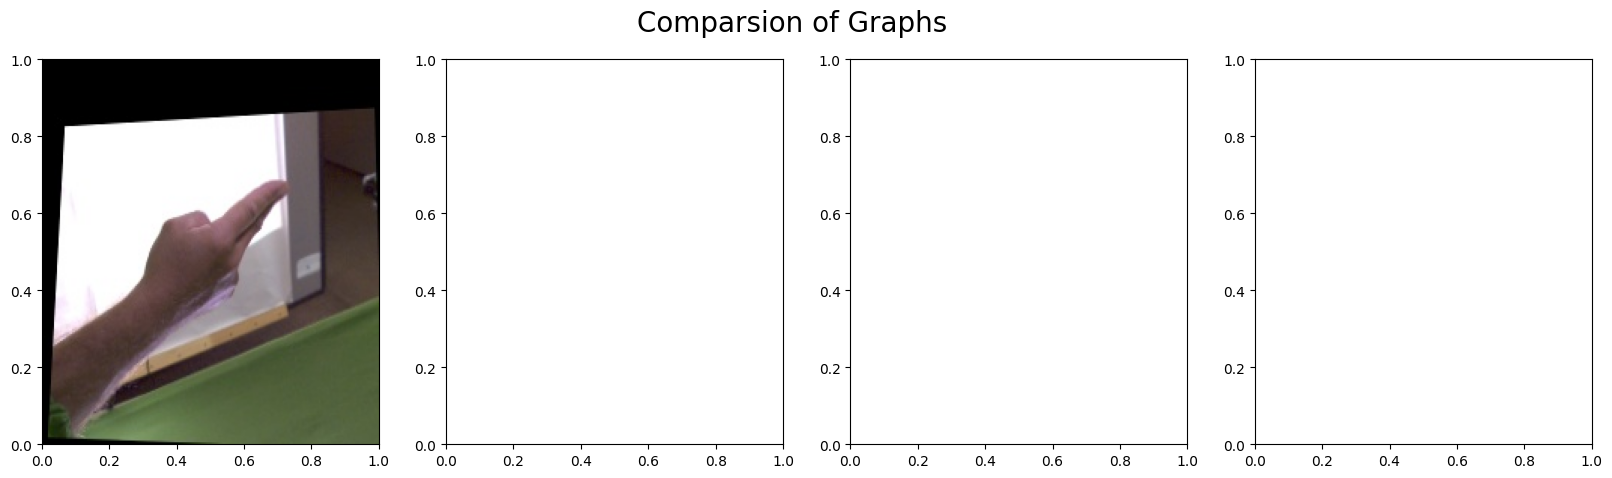

In [13]:
import random
import networkx as nx
import matplotlib.pyplot as plt

def visualize_graphs_side_by_side(dataset, indices):
    num_graphs = len(indices)
    fig, axs = plt.subplots(1, num_graphs, figsize=(5 * num_graphs, 5))
    axs = [axs] if num_graphs == 1 else axs

    fig.suptitle("Comparsion of Graphs", fontsize=20)

    for ax, idx in zip(axs, indices):
        img, real_lms = dataset[idx]
        # mp_lms = data["mediapipe_lms"].numpy()
        # real_lms = data["real_lms"].numpy()
        # img = data["image"].numpy() # shape (H, W, 3), normalized 0-1

        # Background image (fit to 0-1 coordinate space)
        ax.imshow(img, extent=[0, 1, 0, 1], origin='upper', aspect='auto')

        # Graph edges
        edge_index = Hand.compute_edge_index(Hand.anatomical).numpy()
        G = nx.Graph()
        G.add_edges_from(edge_index.T)

        # Node features
        model_lms = inference(model, data)
        x1, y1 = model_lms[:, 0], model_lms[:, 1]
        y1 = 1.0 - y1
        pos_x = {i: (x1[i], y1[i]) for i in range(len(x1))}
        nx.draw_networkx_nodes(G, pos_x, node_size=50, node_color='blue', ax=ax)
        nx.draw_networkx_edges(G, pos_x, width=1.5, alpha=0.7, ax=ax)

        x2, y2 = real_lms[:, 0], real_lms[:, 1]
        y2 = 1.0 - y2
        pos_y = {i: (x2[i], y2[i]) for i in range(len(x2))}
        nx.draw_networkx_nodes(G, pos_y, node_size=50, node_color='red', ax=ax)

        ax.set_aspect('equal', adjustable='box')
        ax.set_xlim(0, 1)
        ax.set_ylim(0, 1)
        ax.invert_yaxis()  # optional, depends on how you want y-axis
        ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True, labelsize=12)
        ax.set_xlabel("X-axis", fontsize=14)
        ax.set_ylabel("Y-axis", fontsize=14)

    plt.tight_layout()
    plt.show()

# Example usage
random_indices = random.sample(range(len(dataset)), 3)
random_indices = [3,4,5,6]
visualize_graphs_side_by_side(valid_dataset, indices=random_indices)